# Titanic: Machine Learning from Disaster

Here we explore the famous [Titanic data set from Kaggle](https://www.kaggle.com/c/titanic/data) and predict whether a passenger would survive or not. 
Let's start by importing some binaries. 

In [1]:
import numpy as np
import pandas as pd
from itertools import groupby
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

/home/akshay/Data/skl-v/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
test = pd.read_csv("./Data/test.csv", index_col=0)
train = pd.read_csv("./Data/train.csv", index_col=0)
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35

There are a total of 11 columns with 891 rows. Following observations can be made just by looking the the output above. 
1. Intuition tell us that the 'Pclass', 'Age', 'Sex', 'Fare' would be few of the factors that decide 'Survived' status.
2. 'Age', 'Cabin' and 'Embarked' have null values. 

Now lets analyse numerical features. 

In [3]:
print (train.describe())

         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


Following observations can be made : 
1. 38% of the passengers in the data survived as compared to actual 32%. That means we have a slightly biased data, so we will ignore that. 
2. More than 50 % of the passengers were in 'Pclass'=3.
3. Average 'Age' of passengers was 29 with max 'Age' being 80. 
4. Around 70% passengers didn't have any siblings or spuse('SibSp'). 
5. Less than 25% of passenger were with their parents/children('Parch')
6. 'Fare' has a very high standard deviation and the max value of 512 shows presence of outliers. 

Lets analyse our non-numerical features. 

In [4]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Vanden Steen, Mr. Leo Peter",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


1. Some 'Ticket'number are alloted to multiple passengers, so we need do adjust the 'Fare' of such tickets accoringly. 
2. 577(64.7%) passengers were male. 
3. 'Cabin' was also shared. 

### Correlating features amongst each other

#### 'Sex' and 'Survived'

In [5]:
# Gender and survived. 
train.loc[:,['Sex','Survived']].groupby(by=['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


74% of females survived as compared to 18% of males. So 'Sex' seems to be a deciding feature.

#### 'Embarked' and 'Survived' 

In [6]:
train.loc[:,['Embarked','Survived']].groupby(by=['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


#### 'Pclass' and 'Survived'

In [7]:
train.loc[:,['Pclass','Survived']].groupby(by=['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


62% of Pclass'=1 survived, while only 24% passengers of 'Pclass'=3 survived. Thus 'Pclass' is also an important feature. 

Now lets plots a correlation matrix to analyse the correlation between different numerical features. 

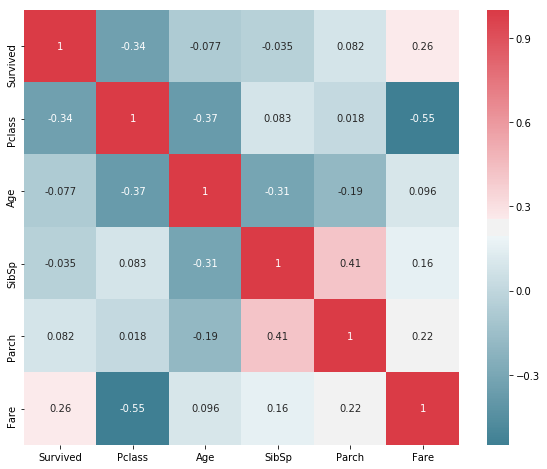

In [8]:
f, ax = plt.subplots(figsize=(10,8))
corr = train.corr()
_= sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

    The above heatmap shows that 'Survived' has a high correlation(relative to others) with 'Fare' and 'Pclass'. Also as we can see there is'nt much of correlation between other features ie there isn;t high collinearity. 

#### 'Survived' and 'Fare'

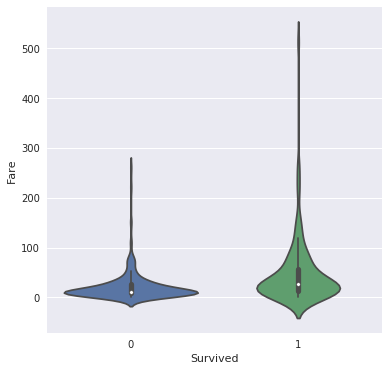

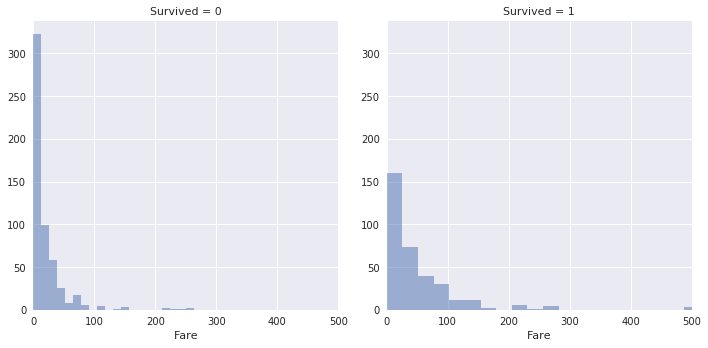

In [9]:
sns.set(style='darkgrid')
_,ax = plt.subplots(figsize=(6,6))
_= sns.violinplot(x='Survived', y='Fare', data=train, ax=ax, scale='count') 
grid = sns.FacetGrid(train, col='Survived', size=5, xlim=(0,500))
grid.map(plt.hist, 'Fare', alpha=0.5, bins=20)


The violinplot has more width for 'Survived'=0 at lower fare region as compared to 'Survived'=1. This implies that that passenger who paid higher fares had high chance of suvival. This is also asserted by the histogram which shows that people paying higher fares had a better percentage of survival. 

### 'Survived' and 'Age'

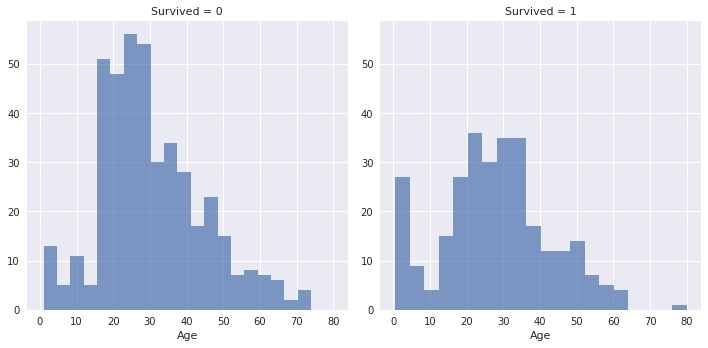

In [10]:
# sns.violinplot(x='Survived', y='Age', data=train)
grid = sns.FacetGrid(train, col='Survived', size=5)
grid.map(plt.hist, 'Age', bins=20, alpha=0.7)

1. Infants(<10years) had a high survival rate. 
2. Large number of the passengers in 15-35 years didn't survive. 
3. Most passengers were in 20-40 years of age. 

#### 'Survived' and 'SibSp'

In [11]:
train[['Survived','SibSp']].groupby(by='SibSp', as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


Passenger with 1 or 2 siblings/spouse high survival rate. 
#### 'Survived' and 'Parch'

In [12]:
train[['Survived','Parch']].groupby(by='Parch', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Passengers with 1,2 or 3 children had a high survival rate. 

## Wrangle Data

We have made several observations about our features and how they correlate with survival rate. Now lets clean, correct, convert our data so that it can be modelled. Note that most of these operations also need to be performed on test data. 

#### Extracting Titles from 'Name'
If we look closely at 'Name' column we find that with every name there is a title associated like Mr, Mrs, Master etc. If we can extract these titles we might add more information and can drop the 'Name' column. 

In [13]:
train['Title'], test['Title'] = ( df.Name.str.extract(r"(\b\w+[.])", expand=False) for df in [train, test])
train, test = (df.drop('Name', axis=1) for df in [train, test])
print (train.Title.isnull().sum(), train.Title.unique())
print (test.Title.isnull().sum(), test.Title.unique())

0 ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'Countess.' 'Jonkheer.']
0 ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Ms.' 'Col.' 'Rev.' 'Dr.' 'Dona.']


As we see there are 18 different titles, with no record being null. Many of these accord a status to passenger and thus can be conveniently grouped as following major categories : 
1. Mrs(0) : Mme, Ms, Mrs, 
2. Mr(1) : Mr
3. Master(2) : Master
4. Miss(3) : Mlle, Miss
5. Royalty(4) : Jonkheer, Don, Dona, Sir, Lady, Countess
6. Officer(5) : Capt, Col, Major, Dr, Rev

We replace the titles by the category number written in paranthesis. 

In [14]:
# Now after 
title_dictionary = {
                        "Capt.":       5,
                        "Col.":        5,
                        "Major.":      5,
                        "Jonkheer.":   4,
                        "Don.":        4,
                        "Dona.":       4,
                        "Sir." :       4,
                        "Dr.":         5,
                        "Rev.":        5,
                        "Countess.":   4,
                        "Mme.":        0,
                        "Mlle.":       3,
                        "Ms.":         0,
                        "Mr." :        1,
                        "Mrs." :       0,
                        "Miss." :      3,
                        "Master." :    2,
                        "Lady." :      4
                        }
train.Title, test.Title = (df.Title.map(title_dictionary) for df in [train, test])

So here Title is a categorical variable which we will dummify later.

#### Drop 'Cabin'
'Cabin' feature can be dropped as it has high number of null values(687 out of 894). Also because of being alphanumeric in nature it might be a futile exercise to fill null values. 


In [15]:
train, test = (df.drop('Cabin', axis=1) for df in [train, test])
print (train.shape, test.shape)
train.info(), test.info()

(891, 10) (418, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Embarked    889 non-null object
Title       891 non-null int64
dtypes: float64(2), int64(5), object(3)
memory usage: 116.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 9 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Embarked    418 non-null object
Title       418 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 32.7+ KB


(None, None)

#### Complete 'Age', 'Embarked', 'Fare'
'Age', 'Embarked' have null values in train while 'Age','Fare' have null values in test. We can fill 'Fare', 'Embarked' with mean, median as only a couple of values are missing. In case of 'Age', 177(out of 891) in train and 86(out of 418) in test. 
we can't just use mean or median as many values are to be filled out and also our our response variable is highly correlated with 'Age'. So what we do is we find out the variables with which 'Age' is highly correlated and using these variables we can regress onto 'Age' to find missing values. 

In [16]:
train.Age.corr(train.Title)

-0.21776131778407989

As we see from the heatmap plotted in the beginning and the correlation value above that 'Age' is highly correlated with 'Title', 'Pclass' and 'SibSp'. So we we will use these 3 variables. 

In [17]:
null_age_df = train.loc[train.Age.isnull(), :]
age_df = train.loc[train.Age.notnull(), :]
lr = LinearRegression()
lr.fit(age_df[['Title','Pclass','SibSp']], age_df.Age)
age_np = np.round(lr.predict(null_age_df[['Title','Pclass','SibSp']]), decimals=0)
train.loc[train.Age.isnull(),['Age']] = age_np.reshape((177,1))

In [18]:
null_age_df = test.loc[test.Age.isnull(), :]
age_df = test.loc[test.Age.notnull(), :]
lr = LinearRegression()
lr.fit(age_df[['Title','Pclass','SibSp']], age_df.Age)
age_np = np.round(lr.predict(null_age_df[['Title','Pclass','SibSp']]), decimals=0)
test.loc[test.Age.isnull(),['Age']] = age_np.reshape((86,1))

In [19]:
# Fill 'Fare' in test using mean. 
test.Fare.fillna(test.Fare.mean(), inplace=True)
# Fill 'Embarked' in train using median. 
train.Embarked.fillna(train.Embarked.value_counts().index[0], inplace=True)

#### Create dummy variables of 'Pclass', 'Sex', 'Title' and 'Embarked'
Since 'Pclass', 'Sex', 'Title' and 'Embarked' are categorical variables, we need to create dummy variables out of them. We don;t need to do so if we plan to use a tree based classifier. 

In [20]:
train, test = (pd.get_dummies(df, columns=['Pclass', 'Sex', 'Embarked','Title']) for df in [train, test])

In [21]:
train.columns, test.columns


(Index(['Survived', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Pclass_1',
        'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C',
        'Embarked_Q', 'Embarked_S', 'Title_0', 'Title_1', 'Title_2', 'Title_3',
        'Title_4', 'Title_5'],
       dtype='object'),
 Index(['Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Pclass_1', 'Pclass_2',
        'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
        'Embarked_S', 'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Title_4',
        'Title_5'],
       dtype='object'))

### Extracting feature from 'SibSp' and 'Parch'
Some of the passengers who were travelling with family(indicated by 'SibSp' and 'Parch') might be more likely to have survived than people travelling alone. So we create a new feature 'FamilySize' by adding 'SibSp' and 'parch'. 

In [22]:
train['FamilySize'], test['FamilySize'] = (df['SibSp']+df['Parch']+1 for df in [train,test])
train[['FamilySize','Survived']].groupby(by='FamilySize', as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


As we see passengers who were a member of small families had a higher rate of survival. We can drop 'SibSp' and 'Parch' now.

In [23]:
train, test = (df.drop(['SibSp','Parch'], axis=1) for df in [train,test])
train.columns, test.columns

(Index(['Survived', 'Age', 'Ticket', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
        'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
        'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Title_5',
        'FamilySize'],
       dtype='object'),
 Index(['Age', 'Ticket', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
        'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
        'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Title_5',
        'FamilySize'],
       dtype='object'))

We will drop 'Ticket' feature as well, since it is alphanumeric in nature and in a real world scenario ticket numbers add little to information. 

In [24]:
train, test = (df.drop('Ticket',axis=1) for df in [train, test])

## Modelling
Looks like we are ready to try various models on our dataset. We will try the following classifiers for now and submit the one with highest accuracy : 
1. Logistic Regression
2. Linear Discriminant Analysis
3. k nearest neighbours 
4. SVM
5. Random Forest Classifier
6. Gradient Boosting classifier
7. XGBoost

For tree based models we don't need to dummify our categorical variables. 


In [25]:
np.random.seed(1)
X = train.drop('Survived', axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


#### Logistic Regression
We chose LogisticRegressionCV classifier from sklearn with 'lbfgs' solver(default one) and 'l2' penalty. The model selects the value of regularization parameter from a list of values using 10 fold cross validation.  

In [147]:
lr = LogisticRegressionCV(cv=10, verbose=1, max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy : {0}".format(accuracy))

Accuracy : 0.8116591928251121


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.2s finished


#### Quadratic Discriminant Analysis
We chose quadratic discriminant analysis over linear as there are a good no of data points and so our primary is to reduce variance by chosing a more flexible model. QDA tries to approximate Bayes decision boundary by assuming that the data is drawn from a multivariate Gaussian distribution with class specific mean and covariance. 

In [148]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy : {0}".format(accuracy))

Accuracy : 0.7668161434977578


/home/akshay/Data/skl-v/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


#### K Nearest Neighbours
We chose number of nearest neighbours using cross validation. 

In [149]:
knn = KNeighborsClassifier()
parameters = {"n_neighbors":np.arange(1,11)}
clf = GridSearchCV(knn, param_grid=parameters, cv=10)
clf.fit(X_train, y_train)
print ("No of neighbours : ", clf.best_estimator_.n_neighbors)
accuracy = accuracy_score(y_test, clf.predict(X_test))
print ("Accuracy : {0}".format(accuracy))

No of neighbours :  3
Accuracy : 0.7174887892376681


#### Support Vector Classifier

In [159]:
svc = SVC(kernel='linear')
parameters = {"C":[0.1,1,5,10]}
clf = GridSearchCV(svc, param_grid=parameters, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print ("kernel : {0}, C : {1}".format(clf.best_estimator_.kernel, clf.best_estimator_.C))
accuracy = accuracy_score(y_test, clf.predict(X_test))
print ("Accuracy : {0}".format(accuracy))

kernel : linear, C : 1
Accuracy : 0.8116591928251121


Training 'RBF', 'poly' as kernel values takes a lot of time so I had to settle with linear kernel. 

#### Random Forest Classifier

In [153]:
rfc = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rfc.fit(X_train, y_train)
accuracy = accuracy_score(y_test, rfc.predict(X_test))
print ("Accuracy : {0}".format(accuracy))

Accuracy : 0.757847533632287


#### Gradient Boosting Classifer 


In [156]:
gbc = GradientBoostingClassifier(max_leaf_nodes=2, n_estimators=100)
parameters = {"learning_rate":np.linspace(0.01, 0.5, 20)}
clf1 = GridSearchCV(gbc, param_grid=parameters, cv=10, n_jobs=-1)
clf1.fit(X_train, y_train)
print (clf1.best_estimator_)
accuracy = accuracy_score(y_test, clf1.predict(X_test))
print ("Accuracy : {0}".format(accuracy))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.061578947368421053, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=2,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Accuracy : 0.8026905829596412


#### XGBoost Classifier

In [41]:
gbx = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=300).fit(X_train, y_train)
accuracy = accuracy_score(y_test, gbx.predict(X_test))
print ("Accuracy : {0}".format(accuracy))

Accuracy : 0.8071748878923767


### Preparing Submission files

In [160]:
y_pred = lr.predict(test)
submission_df = pd.DataFrame(y_pred, index=test.index, columns=['Survived'])
submission_df.to_csv("final_logR.csv")
y_pred = clf.predict(test)
submission_df = pd.DataFrame(y_pred, index=test.index, columns=['Survived'])
submission_df.to_csv("final_svc.csv")
y_pred = clf1.predict(test)
submission_df = pd.DataFrame(y_pred, index=test.index, columns=['Survived'])
submission_df.to_csv("final_gbc2.csv")
y_pred = gbx.predict(test)
submission_df = pd.DataFrame(y_pred, index=test.index, columns=['Survived'])
submission_df.to_csv("final_gbx.csv")

Submit these files and see which gives better results. 
